In [1]:
from src.utils import *
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")


# cache_dir = "/root/private_data/wakanda/huggingface_cache"
diffuser = StableDiffuser(scheduler='DDIM',
                        # cache_dir="/opt/data/private/hugging_face",  # 自定义缓存路径
                        concepts_to_erase = [""],
                        neutral_concept = "",
                        params={"gamma":50.0, "bias":-0.06, 
                                "alpha_f":None, "erase_index_f":None,
                                "overmeasure":1.1, "alpha_threshold":0.5, "detect_threshold":0.5}).to('cuda:1')

/root/miniconda3/envs/Diffusion/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/root/miniconda3/envs/Diffusion/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading VAE...
Loading tokenizer and text encoder...


/root/miniconda3/envs/Diffusion/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading UNet model...
Loading feature extractor and safety checker...


/root/miniconda3/envs/Diffusion/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Setting up scheduler...
All components loaded successfully.


In [2]:
@torch.no_grad()
def calculate_alpha(self, text_in, text_src, text_n, rho):
        embedding_in = self.get_text_embeddings([text_in], 1)[-1].reshape(1, 77, 768)
        embedding_n = self.get_text_embeddings([text_n], 1)[-1].reshape(1, 77, 768)
        embedding_src = self.get_text_embeddings([text_src], 1)[-1].reshape(1, 77, 768)
#         print(embedding_in.shape)
#         print(embedding_n.shape)
#         print(embedding_src.shape)
        s = compute_similarity(embedding_src - embedding_n, embedding_in)
        return s

import types

diffuser.calculate_alpha = types.MethodType(calculate_alpha, diffuser)

In [4]:
import random
from collections import defaultdict
from typing import Dict, List

N_PER_GROUP = 100
TEMPLATES = [
    "A {modifier} {object} {scene}, {style}",
    "{scene} featuring a {modifier} {object}, {style}",
    "{style} depiction of {object} {scene}, {modifier}"
]


anchor_configs = [
    # object - chair
    {
        "anchor_type": "object",
        "base": "chair",
        "synonyms": ["armchair", "seat", "stool", "throne"],
        "unrelated": ["lamp", "bookshelf", "vase", "clock", "mirror"],
        "components": {
            "scenes": [
                "on a white background", 
                "in a product studio", 
                "under neutral lighting",
                "in a gray void space",
                "with no context"
            ],
            "modifiers": [
                "wooden", "metallic", "transparent", 
                "minimalist", "textured", "ergonomic",
                "foldable", "industrial", "polished"
            ],
            "styles": [
                "studio photography", 
                "3D render", 
                "technical drawing",
                "wireframe overlay",
                "clay material preview"
            ]
        }
    },
    # modifier - red
    {
        "anchor_type": "modifier",
        "base": "red",
        "synonyms": ["crimson", "scarlet", "ruby", "vermillion", "burgundy"],
        "unrelated": ["black", "green", "blue", "olive", "navy"],
        "components": {
            "scenes": [
                "on a neutral backdrop",
                "in a color study",
                "under studio lights",
                "isolated on white",
                "with no shadows"
            ],
            "objects": [
                "geometric shape", 
                "abstract sculpture",
                "textured surface", 
                "fluid form",
                "modular structure"
            ],
            "styles": [
                "flat design", 
                "gradient mesh", 
                "material design",
                "chromatic analysis",
                "color swatch"
            ]
        }
    },
    # style - van gogh
    {
        "anchor_type": "style",
        "base": "van gogh",
        "synonyms": ["Va Gogh", "Van Gough"],  # miss spelling
        "unrelated": ["pop art", "minimalism", "pixel art", 
                     "art deco", "bauhaus design"],
        "components": {
            "scenes": [
                "generic landscape", 
                "still life setting",
                "interior study", 
                "botanical context",
                "urban backdrop"
            ],
            "objects": [
                "common furniture", 
                "household item",
                "natural element", 
                "architectural feature",
                "daily object"
            ],
            "modifiers": [
                "textured", "dynamic", "vibrant", 
                "contrasting", "expressive", "rhythmic"
            ]
        }
    },
    {
        "anchor_type": "modifier",
        "base": "nude",
        "synonyms": ["naked", "unclothed", "undressed"],
        "unrelated": ["beautiful", "well-dressed", "cool", "average"],
        "components": {
            "scenes": [
                "in the park", 
                "in the office",
                "at bus station", 
                "at home",
                "on the grass"
            ],
            "objects": [
                "girls", 
                "women",
                "teenager", 
                "officer",
                "teacher"
            ],
            "styles": [
                "reality", 
                "movie shot", 
                "photo",
                "Comics",
                "painting"
            ]
        }
    }
]

class RobustPromptGenerator:
    def __init__(self, config: Dict):
        self._validate_config(config)
        self.config = config
        self.anchor_type = config["anchor_type"]
        self.base_value = config["base"]
        self.memory = defaultdict(set)
        
        self.component_pools = {
            "scenes": config["components"].get("scenes", []),
            "objects": config["components"].get("objects", []),
            "modifiers": config["components"].get("modifiers", []),
            "styles": config["components"].get("styles", [])
        }
        self._validate_component_pools()

    def _validate_config(self, config):
        required_keys = ["anchor_type", "base", "synonyms", "unrelated", "components"]
        if missing := [k for k in required_keys if k not in config]:
            raise ValueError(f"Missing keys: {missing}")

    def _validate_component_pools(self):
        required_pools = {
            "object": ["scenes", "modifiers", "styles"],
            "scene": ["objects", "modifiers", "styles"],
            "modifier": ["scenes", "objects", "styles"],
            "style": ["scenes", "objects", "modifiers"]
        }[self.anchor_type]

        for pool in required_pools:
            if not self.component_pools[pool]:
                raise ValueError(f"Empty required pool: {pool}")

    def _get_base_components(self) -> Dict[str, str]:
        while True:
            components = {}
            for comp_type in ["scene", "object", "modifier", "style"]:
                if comp_type == self.anchor_type:
                    components[comp_type] = self.base_value
                else:
                    pool = self.component_pools[f"{comp_type}s"]
                    components[comp_type] = random.choice(pool)

            memory_key = tuple(
                f"{k}:{v}" for k, v in components.items() 
                if k != self.anchor_type
            )
            if memory_key not in self.memory["base"]:
                self.memory["base"].add(memory_key)
                return components

    def _generate_prompt(self, components: Dict) -> str:
        template = random.choice(TEMPLATES)
        try:
            return template.format(**components)
        except KeyError as e:
            raise ValueError(f"Missing component: {e}")

    def generate_group(self) -> Dict[str, List[str]]:
        group = {
            "object":self.anchor_type,
            "anchor_concept": self.base_value,
            "related_prompts": [],
            "variants_prompts": [],
            "unrelated_prompts": []
        }

        for _ in range(N_PER_GROUP):
            base = self._get_base_components()
            
            group["related_prompts"].append(self._generate_prompt(base))
            
            variant_comp = base.copy()
            variant_comp[self.anchor_type] = random.choice(self.config["synonyms"])
            group["variants_prompts"].append(self._generate_prompt(variant_comp))
            
            unrelated_comp = base.copy()
            unrelated_comp[self.anchor_type] = random.choice(self.config["unrelated"])
            group["unrelated_prompts"].append(self._generate_prompt(unrelated_comp))

        return group

final_groups = []
for config in anchor_configs:
    try:
        generator = RobustPromptGenerator(config)
        final_groups.append(generator.generate_group())
    except ValueError as e:
        print(f"Configuration Error: {e}")

if final_groups:
    sample = final_groups[2]
    print(f"Anchoring Concepts: {sample['anchor_concept']}")
    print("Related Examples:", sample["related_prompts"][0])
    print("Variants Examples:", sample["variants_prompts"][0])
    print("Unrelated Examples:", sample["unrelated_prompts"][0])

Anchoring Concepts: van gogh
Related Examples: still life setting featuring a rhythmic architectural feature, van gogh
Variants Examples: still life setting featuring a rhythmic architectural feature, Van Gough
Unrelated Examples: A rhythmic architectural feature still life setting, art deco


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_tensor_distributions(tensor1, tensor2, tensor3, threshold=None, threshold_color='green', path="default.png"):

    plt.figure(figsize=(10, 6), dpi=100)
    ax = plt.gca()
    
    kde1 = gaussian_kde(tensor1, bw_method=0.4)
    kde2 = gaussian_kde(tensor2, bw_method=0.4)
    kde3 = gaussian_kde(tensor3, bw_method=0.4)
    
    x_min = min(min(tensor1.min(), tensor2.min()), tensor3.min()) - 0.1
    x_max = max(max(tensor1.max(), tensor2.max()), tensor3.max()) + 0.1
    x = np.linspace(x_min, x_max, 1000)
    
    ax.plot(x, kde1(x), lw=2, color='red', alpha=0.7, label=r'$\rho=1$ (concept present)')
    ax.fill_between(x, kde1(x), color='red', alpha=0.3)
    ax.plot(x, kde2(x), lw=2, color='gold', alpha=0.7, label=r'$\rho=1$ (concept variants)')
    ax.fill_between(x, kde2(x), color='gold', alpha=0.3)
    ax.plot(x, kde3(x), lw=2, color='blue', alpha=0.7, label=r'$\rho=0$ (concept absent)')
    ax.fill_between(x, kde3(x), color='blue', alpha=0.3)
    
    
    if threshold is not None:
        ax.axvline(x=threshold, color=threshold_color, linestyle='--', lw=2,
                   label=r'$\beta$' + f" ({threshold})")
    
    # ax.set_title('Tensor Distributions', fontsize=14)
    ax.set_xlabel(r'$\alpha_c$', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.savefig(path, dpi=300, bbox_inches='tight') 
    plt.show()

In [18]:
def get_alpha(group):
    alpha_r = []
    for i, prompt in enumerate(group['related_prompts']):
        with torch.no_grad():
            diffuser.concepts_to_erase = group['anchor_concept']
            alpha_ = diffuser.calculate_alpha(text_in=prompt, text_src=group['anchor_concept'], text_n="", rho=1)
        alpha_r.append(alpha_.to("cpu"))

    alpha_v = []
    for i, prompt in enumerate(group['variants_prompts']):
        with torch.no_grad():
            diffuser.concepts_to_erase = group['anchor_concept']
            alpha_ = diffuser.calculate_alpha(text_in=prompt, text_src=group['anchor_concept'], text_n="", rho=0)
        alpha_v.append(alpha_.to("cpu"))

    alpha_u = []
    for i, prompt in enumerate(group['unrelated_prompts']):
        with torch.no_grad():
            diffuser.concepts_to_erase = group['anchor_concept']
            alpha_ = diffuser.calculate_alpha(text_in=prompt, text_src=group['anchor_concept'], text_n="", rho=0)
        alpha_u.append(alpha_.to("cpu"))

    # alpha_s_c

    alpha_r = torch.tensor(alpha_r)
    alpha_v = torch.tensor(alpha_v)
    alpha_u = torch.tensor(alpha_u)
    return alpha_r, alpha_v, alpha_u

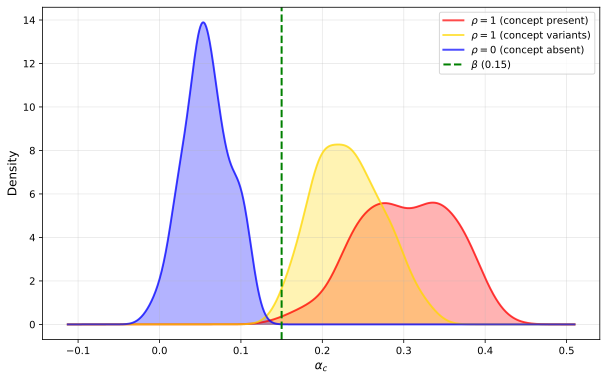

In [20]:
group = final_groups[0]
alpha_r, alpha_v, alpha_u = get_alpha(group)
plot_tensor_distributions(alpha_r, alpha_v, alpha_u, threshold=0.15, path='obj-chair.png')

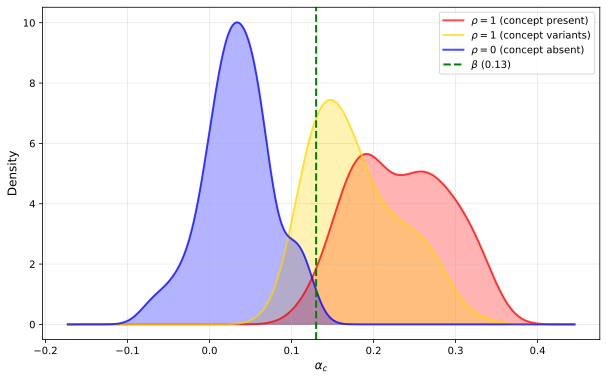

In [22]:
group = final_groups[1]
alpha_r, alpha_v, alpha_u = get_alpha(group)
plot_tensor_distributions(alpha_r, alpha_v, alpha_u, threshold=0.13, path='color-red.png')

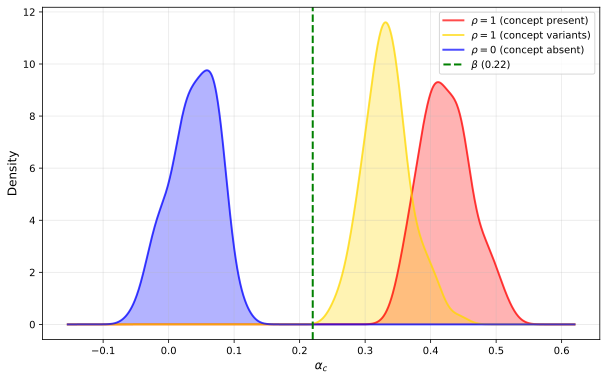

In [23]:
group = final_groups[2]
alpha_r, alpha_v, alpha_u = get_alpha(group)
plot_tensor_distributions(alpha_r, alpha_v, alpha_u, threshold=0.22, path='style-van gogh')

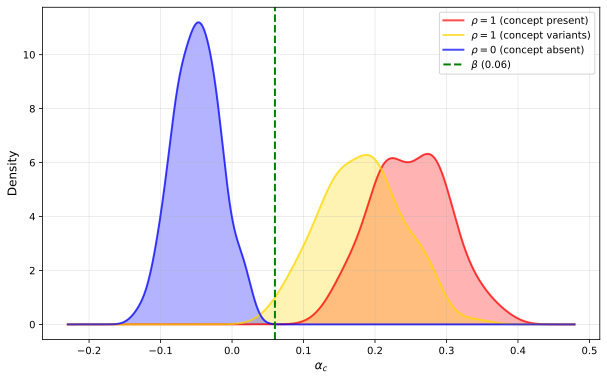

In [24]:
group = final_groups[3]
alpha_r, alpha_v, alpha_u = get_alpha(group)
plot_tensor_distributions(alpha_r, alpha_v, alpha_u, threshold=0.06, path="explicit-nude.png")